In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean

# Initialize Spark session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load data
data_path = "/content/dataset.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show()
# Check for missing values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Handle missing values in TotalCharges
df = df.withColumn("TotalCharges", when(col("TotalCharges") == " ", None).otherwise(col("TotalCharges").cast("float")))
df = df.na.drop(subset=["TotalCharges"])


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

In [ ]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns
categorical_cols = ["gender", "InternetService", "PaymentMethod", "Contract", "Churn"]

# Indexing categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(df) for col in categorical_cols]

# Apply indexers
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)


In [ ]:
from pyspark.sql.functions import expr

# Create new feature: Average Monthly Charges
df = df.withColumn("AvgMonthlyCharges", expr("TotalCharges / tenure"))


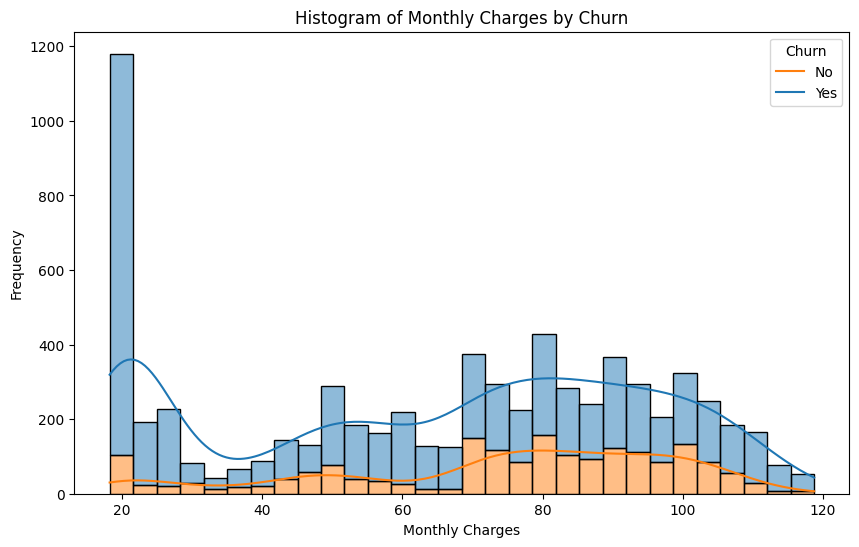

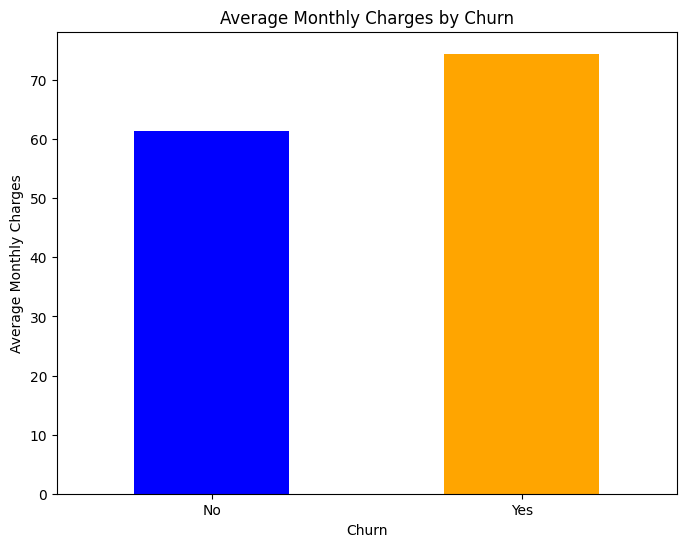

<ipython-input-6-f7653fe11aad>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pandas_df, x="Churn", y="MonthlyCharges", palette="Set2")


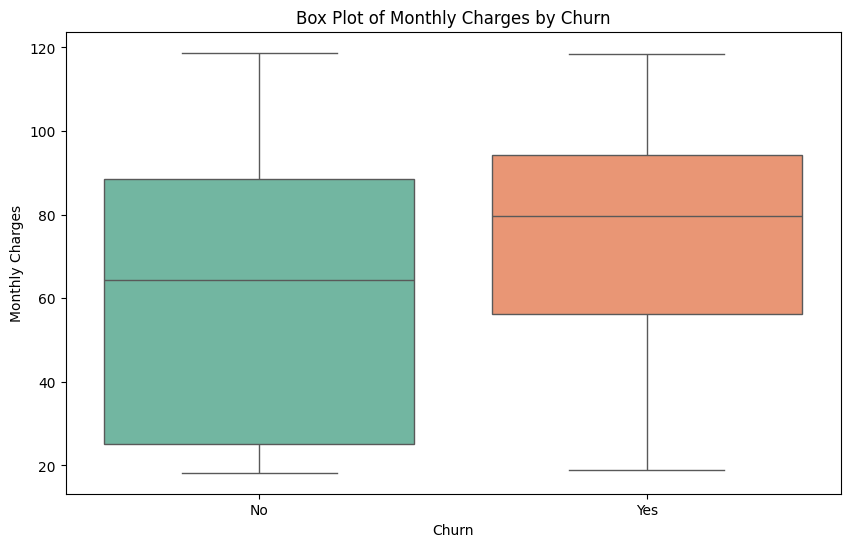

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data to Pandas for easy plotting
pandas_df = df.toPandas()

# 1. Histogram of Monthly Charges by Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="MonthlyCharges", hue="Churn", bins=30, kde=True, multiple="stack")
plt.title("Histogram of Monthly Charges by Churn")
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.show()

# 2. Bar Chart of Average Monthly Charges by Churn
plt.figure(figsize=(8, 6))
pandas_df.groupby("Churn")["MonthlyCharges"].mean().plot(kind="bar", color=["blue", "orange"])
plt.title("Average Monthly Charges by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Monthly Charges")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()

# 3. Box Plot of Monthly Charges by Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=pandas_df, x="Churn", y="MonthlyCharges", palette="Set2")
plt.title("Box Plot of Monthly Charges by Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()


In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges", "AvgMonthlyCharges"]
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df = assembler.transform(df)

correlation_matrix = Correlation.corr(df, vector_col).head()[0].toArray()
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
 [[1.         0.24267348 0.8065302  0.23600201]
 [0.24267348 1.         0.6510648  0.99580483]
 [0.8065302  0.6510648  1.         0.65106218]
 [0.23600201 0.99580483 0.65106218 1.        ]]


In [ ]:
df.groupBy("Churn_index").count().show()


+-----------+-----+
|Churn_index|count|
+-----------+-----+
|        0.0| 5163|
|        1.0| 1869|
+-----------+-----+



In [11]:
train, test = df.randomSplit([0.8, 0.2], seed=42)


In [12]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

# Logistic Regression
lr = LogisticRegression(labelCol="Churn_index", featuresCol="features")
lr_model = lr.fit(train)

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Churn_index", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)

# Gradient Boosting Classifier
gbt = GBTClassifier(labelCol="Churn_index", featuresCol="features", maxIter=100)
gbt_model = gbt.fit(train)


In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_predictions(predictions, label_col="Churn_index", prediction_col="prediction"):
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="f1")

    accuracy = evaluator_accuracy.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)

    return accuracy, precision, recall, f1_score

# Logistic Regression
lr_predictions = lr_model.transform(test)
lr_metrics = evaluate_predictions(lr_predictions)
print(f"Logistic Regression - Accuracy: {lr_metrics[0]:.4f}, Precision: {lr_metrics[1]:.4f}, Recall: {lr_metrics[2]:.4f}, F1-Score: {lr_metrics[3]:.4f}")

# Random Forest
rf_predictions = rf_model.transform(test)
rf_metrics = evaluate_predictions(rf_predictions)
print(f"Random Forest - Accuracy: {rf_metrics[0]:.4f}, Precision: {rf_metrics[1]:.4f}, Recall: {rf_metrics[2]:.4f}, F1-Score: {rf_metrics[3]:.4f}")

# Gradient Boosting
gbt_predictions = gbt_model.transform(test)
gbt_metrics = evaluate_predictions(gbt_predictions)
print(f"Gradient Boosting - Accuracy: {gbt_metrics[0]:.4f}, Precision: {gbt_metrics[1]:.4f}, Recall: {gbt_metrics[2]:.4f}, F1-Score: {gbt_metrics[3]:.4f}")


Logistic Regression - Accuracy: 0.7854, Precision: 0.7708, Recall: 0.7854, F1-Score: 0.7723
Random Forest - Accuracy: 0.7906, Precision: 0.7759, Recall: 0.7906, F1-Score: 0.7744
Gradient Boosting - Accuracy: 0.7750, Precision: 0.7591, Recall: 0.7750, F1-Score: 0.7619


In [22]:
import pandas as pd

metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [lr_metrics[0], rf_metrics[0], gbt_metrics[0]],
    "Precision": [lr_metrics[1], rf_metrics[1], gbt_metrics[1]],
    "Recall": [lr_metrics[2], rf_metrics[2], gbt_metrics[2]],
    "F1-Score": [lr_metrics[3], rf_metrics[3], gbt_metrics[3]]
})

print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.785395   0.770786  0.785395  0.772284
1        Random Forest  0.790611   0.775874  0.790611  0.774393
2    Gradient Boosting  0.774963   0.759099  0.774963  0.761876


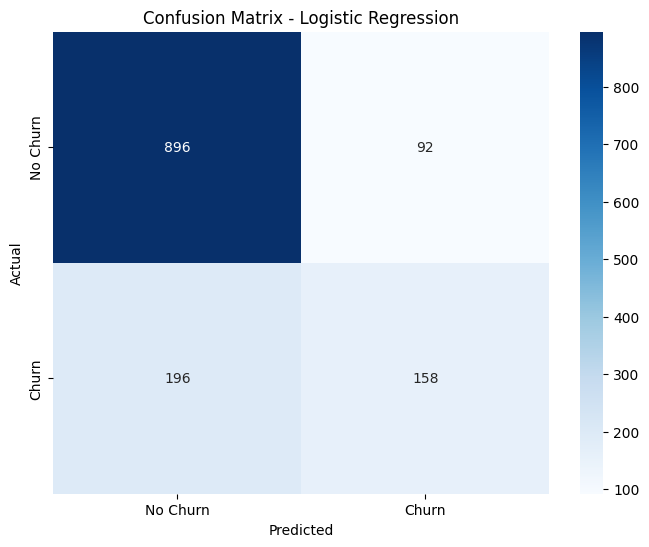

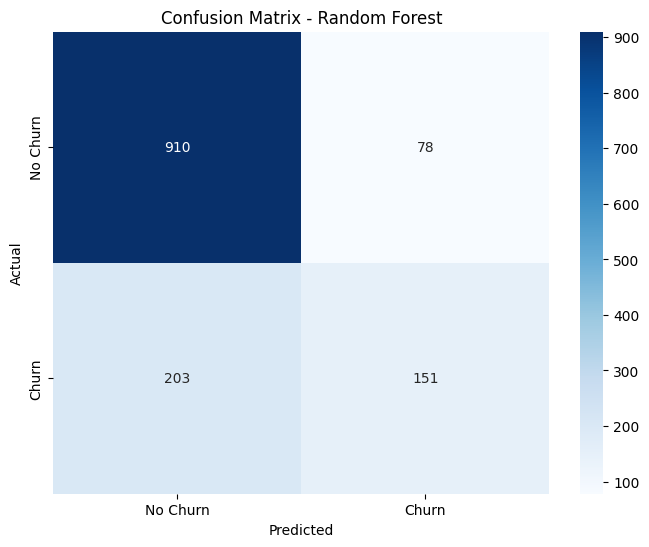

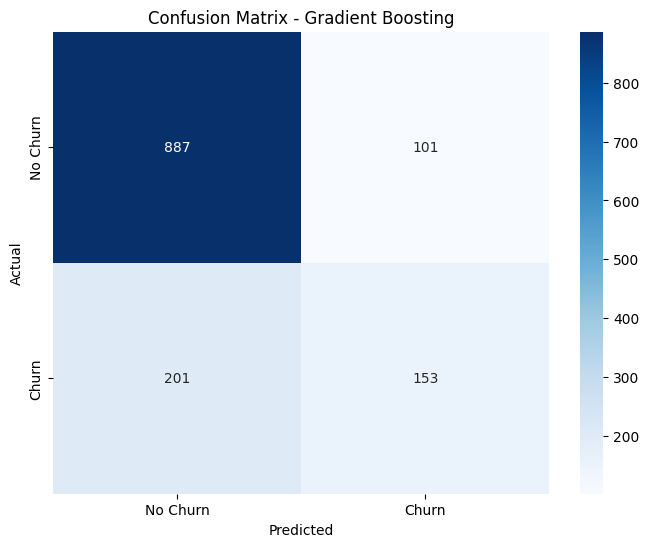

In [23]:
from pyspark.sql.functions import col

def plot_confusion_matrix(predictions, model_name="Model"):
    # Compute confusion matrix
    confusion_matrix = (
        predictions.groupBy("Churn_index", "prediction")
        .count()
        .toPandas()
        .pivot(index="Churn_index", columns="prediction", values="count")
        .fillna(0)
    )

    # Plot confusion matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Example for Logistic Regression
plot_confusion_matrix(lr_predictions, model_name="Logistic Regression")

# Similarly, for Random Forest and Gradient Boosting
plot_confusion_matrix(rf_predictions, model_name="Random Forest")
plot_confusion_matrix(gbt_predictions, model_name="Gradient Boosting")


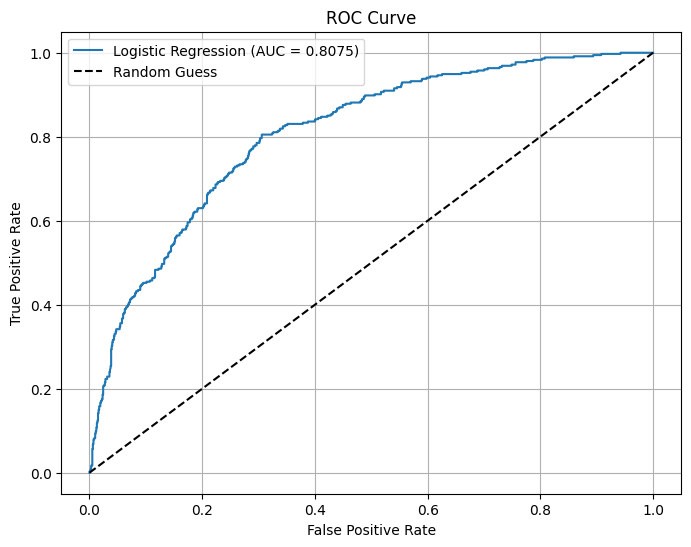

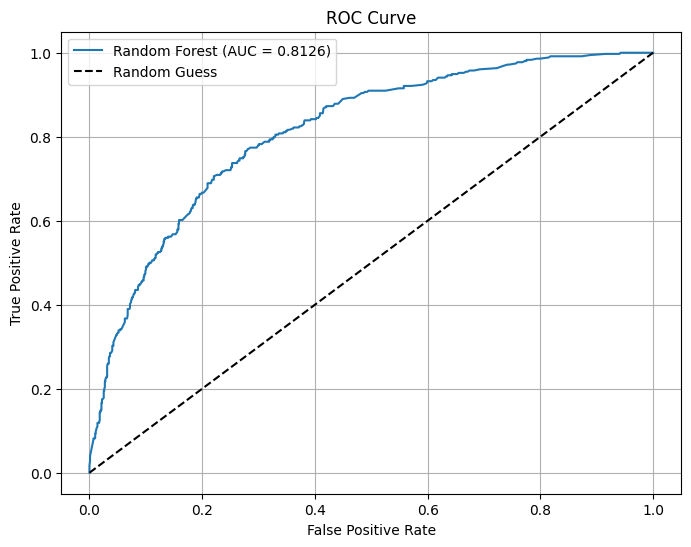

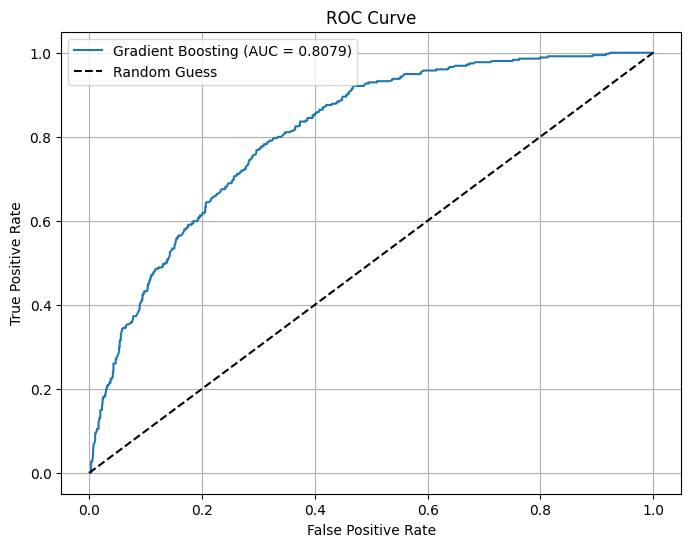

In [24]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(predictions, model_name="Model"):
    # Extract probabilities and labels
    roc_data = predictions.select("Churn_index", "probability").rdd.map(lambda row: (row[0], float(row[1][1]))).collect()
    labels, probabilities = zip(*roc_data)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Example for Logistic Regression
plot_roc_curve(lr_predictions, model_name="Logistic Regression")

# Similarly, for Random Forest and Gradient Boosting
plot_roc_curve(rf_predictions, model_name="Random Forest")
plot_roc_curve(gbt_predictions, model_name="Gradient Boosting")


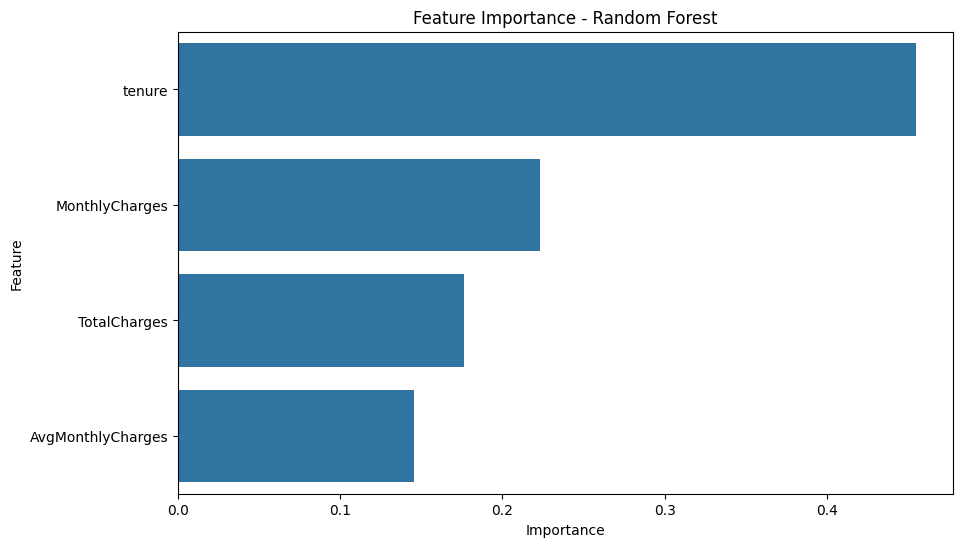

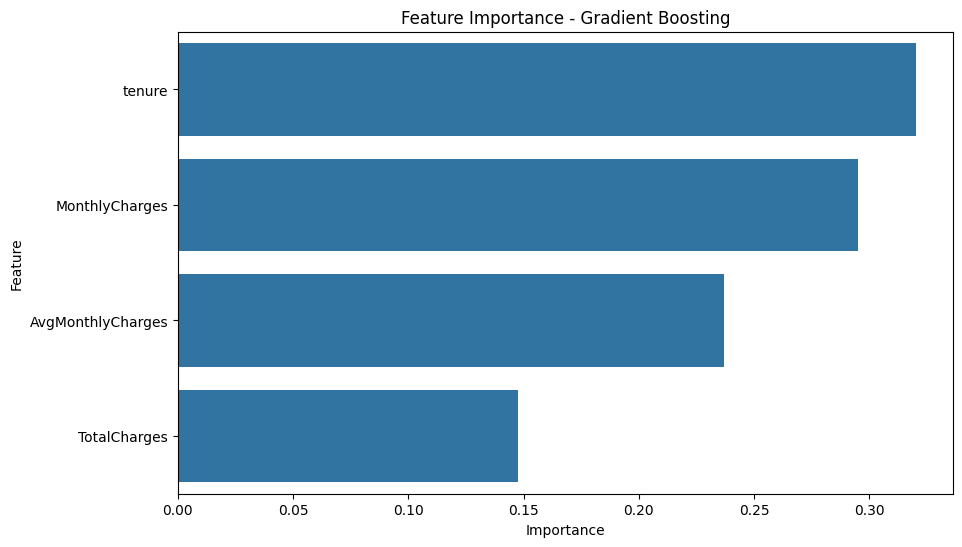

In [27]:
def plot_feature_importance(model, feature_names, model_name="Model"):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Extract feature importances
    feature_importances = model.featureImportances.toArray()
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title(f"Feature Importance - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Example for Random Forest
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges", "AvgMonthlyCharges"]
plot_feature_importance(rf_model, numeric_cols, model_name="Random Forest")
plot_feature_importance(gbt_model, numeric_cols, model_name="Gradient Boosting")
